In [1]:
import os
import time
import glob
import datetime
import tensorflow as tf
from IPython import display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


IMG_SIZE = 128
BATCH_SIZE = 1
OUTPUT_CHANNELS = 3
LAMBDA = 100

In [2]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.ReLU())
    return result


def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())
    return result


def Generator():
    inputs = tf.keras.layers.Input(shape=[IMG_SIZE, IMG_SIZE, 3])

    down_stack = [
        downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
        downsample(128, 4),  # (batch_size, 64, 64, 128)
        downsample(256, 4),  # (batch_size, 32, 32, 256)
        downsample(512, 4),  # (batch_size, 16, 16, 512)
        downsample(1024, 4),  # (batch_size, 8, 8, 512)
        downsample(1024, 4),  # (batch_size, 4, 4, 512)
        downsample(1024, 4),  # (batch_size, 2, 2, 512)
        #downsample(512, 4),  # (batch_size, 1, 1, 512)
    ]

    up_stack = [
        #upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
        upsample(1024, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
        upsample(1024, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
        upsample(512, 4),  # (batch_size, 16, 16, 1024)
        upsample(256, 4),  # (batch_size, 32, 32, 512)
        upsample(128, 4),  # (batch_size, 64, 64, 256)
        upsample(64, 4),  # (batch_size, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4, strides=2, padding='same', kernel_initializer=initializer, activation='sigmoid')  # (batch_size, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)
    return tf.keras.Model(inputs=inputs, outputs=x)


def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    # Mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (LAMBDA * l1_loss)
    return total_gen_loss, gan_loss, l1_loss


def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[IMG_SIZE, IMG_SIZE, 3], name='input_image')
    tar = tf.keras.layers.Input(shape=[IMG_SIZE, IMG_SIZE, 3], name='target_image')

    x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

    down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
    down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
    down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

    last = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)
    return tf.keras.Model(inputs=[inp, tar], outputs=last)


def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss
    return total_disc_loss


def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15, 15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i])
        plt.axis('off')
    plt.show()


@tf.function
def train_step(input_image, target, step):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

    with summary_writer.as_default():
        tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
        tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
        tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
        tf.summary.scalar('disc_loss', disc_loss, step=step//1000)


def fit(train_ds, test_ds, epochs, steps):
    example_input, example_target = next(iter(test_ds.take(1)))
    start = time.time()

    for step, (input_image, target) in train_ds.repeat(epochs).take(steps).enumerate():
        if (step) % 1000 == 0:
            display.clear_output()

            if step != 0:
                print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

            start = time.time()

            generate_images(generator, example_input, example_target)
            print(f"Step: {step//1000}k")

        train_step(input_image, target, step)

        # Training step
        if (step+1) % 10 == 0:
            print('.', end='', flush=True)

        # Save (checkpoint) the model every 5k steps
        if (step + 1) % 5000 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

In [3]:
def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.io.decode_jpeg(image)
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = (image / 255)
    return image


def load_Tensor(U, E):
    E_dataset = tf.data.Dataset.list_files(E, shuffle=False)
    E_dataset = E_dataset.map(load, num_parallel_calls=tf.data.AUTOTUNE)
    U_dataset = tf.data.Dataset.list_files(U, shuffle=False)
    U_dataset = U_dataset.map(load, num_parallel_calls=tf.data.AUTOTUNE)

    dataset = tf.data.Dataset.zip((U_dataset, E_dataset))
    dataset = dataset.shuffle(dataset.cardinality())
    dataset = dataset.batch(BATCH_SIZE)
    return dataset


def get_Users(folder):
    _dirs = [f for f in glob.glob(folder+'*') if os.path.isdir(f) and f.split('_')[-2] == 'E']
    unique_users = list(set([n.split('\\')[-1].split('_')[0] for n in _dirs]))
    train_users, test_users = train_test_split(unique_users, test_size=0.05)
    train_users, validation_users = train_test_split(train_users, test_size=0.3)
    return train_users, test_users, validation_users


def get_Dataset(folder, users):
    E_dirs = [f for f in glob.glob(folder+'*') if os.path.isdir(f) and f.split('_')[-2] == 'E']
    U_dirs = [f for f in glob.glob(folder+'*') if os.path.isdir(f) and f.split('_')[-2] == 'U']

    E_ = [f+'/*' for f in E_dirs if f.split('\\')[-1].split('_')[0] in users]
    U_ = [f+'/*' for f in U_dirs if f.split('\\')[-1].split('_')[0] in users]

    _data = load_Tensor(U_, E_)
    return _data

In [4]:
dataset_path = 'Squared_Heads_Pose/'
train, test, valid = get_Users(dataset_path)
print(len(train), len(test), len(valid))

105 8 46


In [5]:
test_dataset = get_Dataset(dataset_path, test)
train_dataset = get_Dataset(dataset_path, train)
valid_dataset = get_Dataset(dataset_path, valid)

print(len(train_dataset), len(valid_dataset), len(test_dataset))

61672 27731 4800


Clique duas vezes aqui to check if the dataset is loaded correctly
<!--
import cv2
for images in train_dataset.take(12000):
    img = cv2.hconcat([images[0][0].numpy(), images[1][0].numpy()])
    cv2.imshow('image', cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
    k = cv2.waitKey(0)
    if k == 27:
        break
cv2.destroyAllWindows()
-->

In [6]:
generator = Generator()

In [7]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [8]:
discriminator = Discriminator()

In [9]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [10]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [12]:
log_dir="logs/"
summary_writer = tf.summary.create_file_writer(log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [13]:
!del /q %TMP%\.tensorboard-info\*
%reload_ext tensorboard
%tensorboard --logdir {log_dir}  --host localhost
display.clear_output()
### go to http://localhost:6006/

Time taken for 1000 steps: 71.24 sec



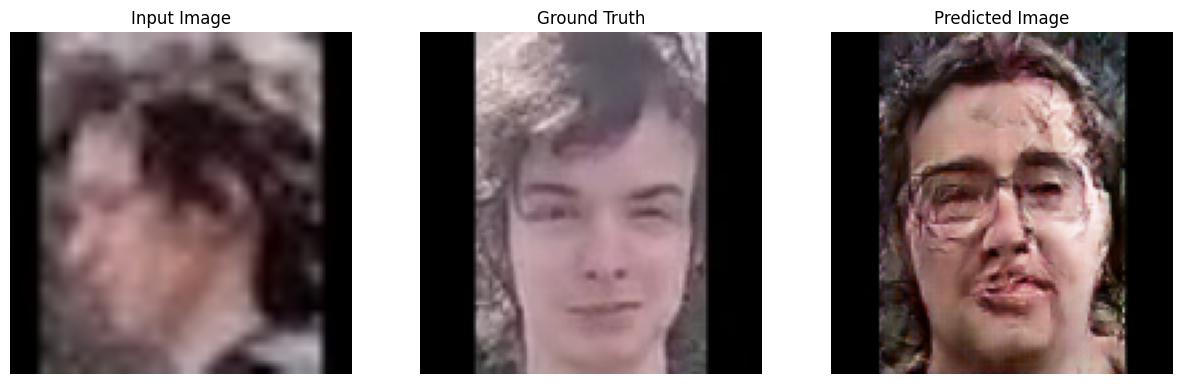

Step: 189k
........................................................

In [15]:
fit(train_dataset, valid_dataset, epochs=3, steps=-1)

In [ ]:
#%ls {checkpoint_dir}

In [ ]:
# Restoring the latest checkpoint in checkpoint_dir
#checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

['025', '008', '012', '102', '001', '072', '104', '129']


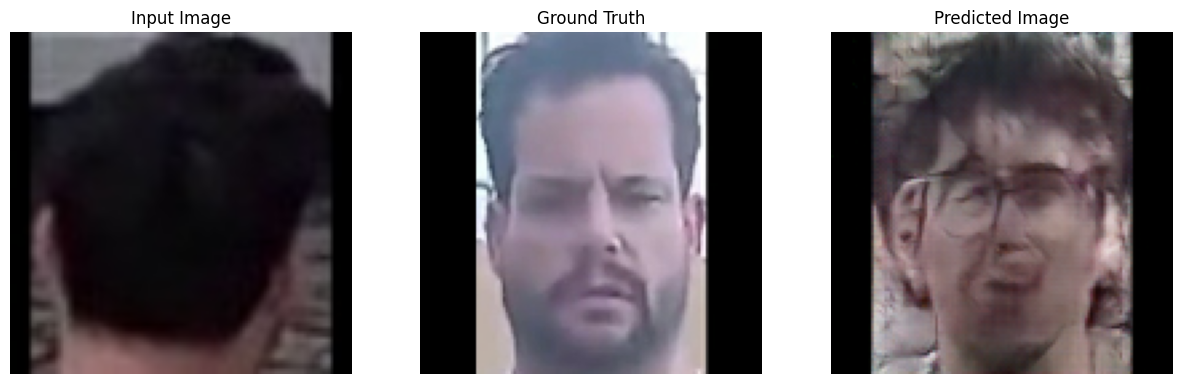

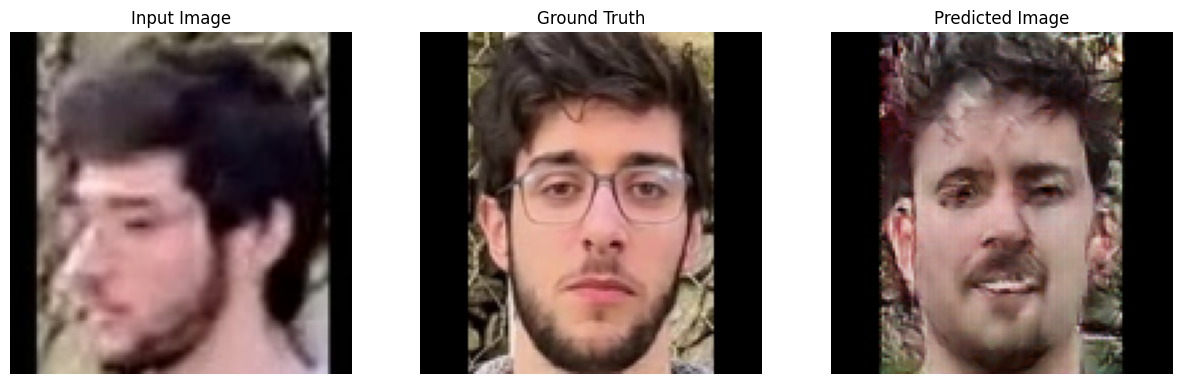

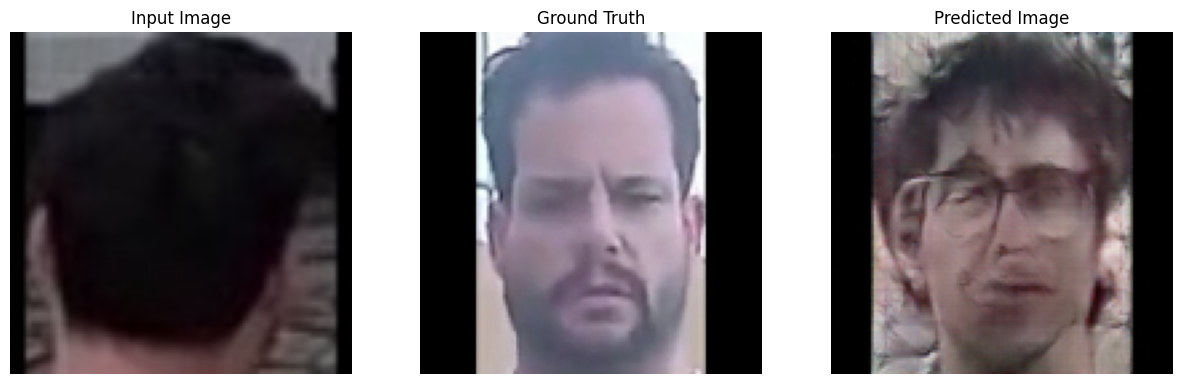

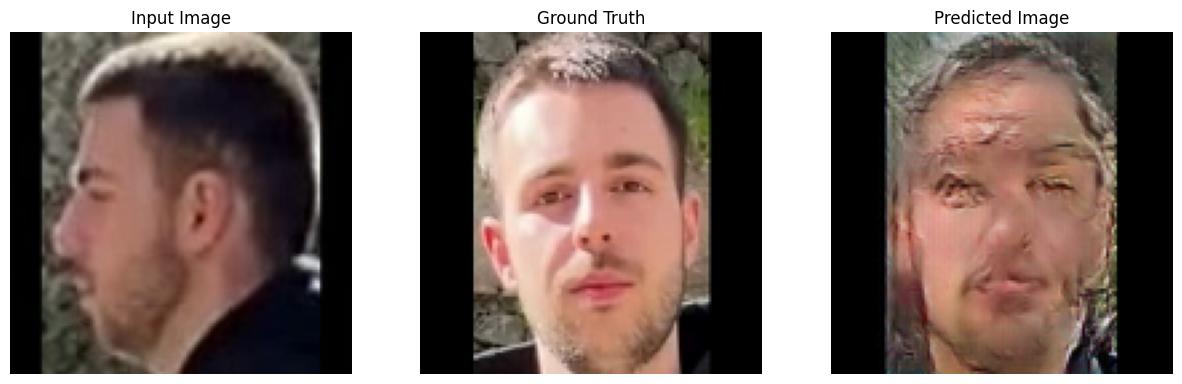

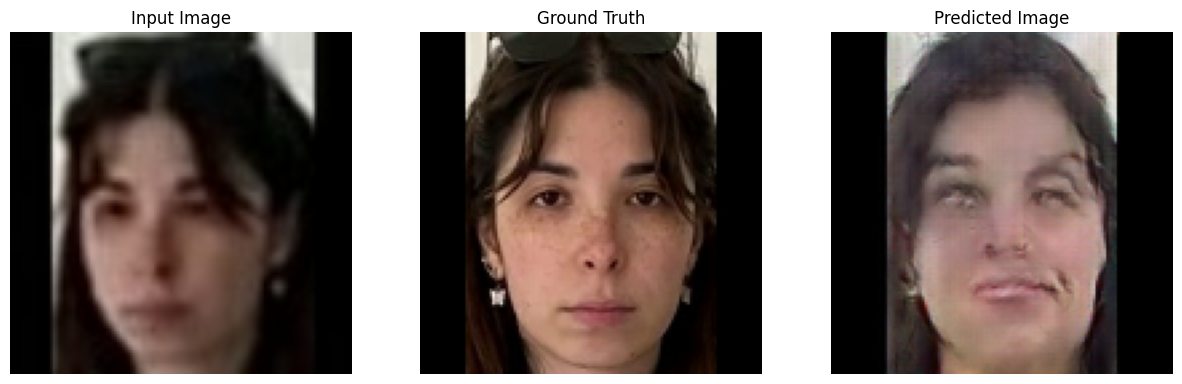

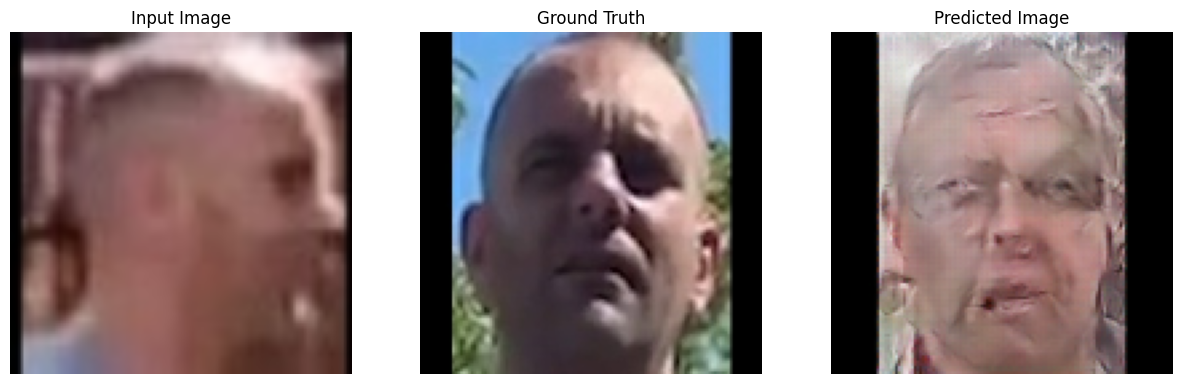

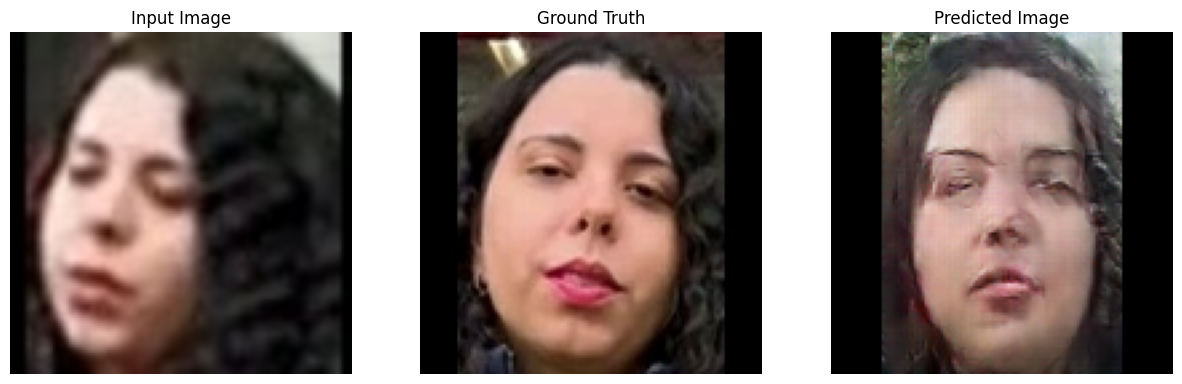

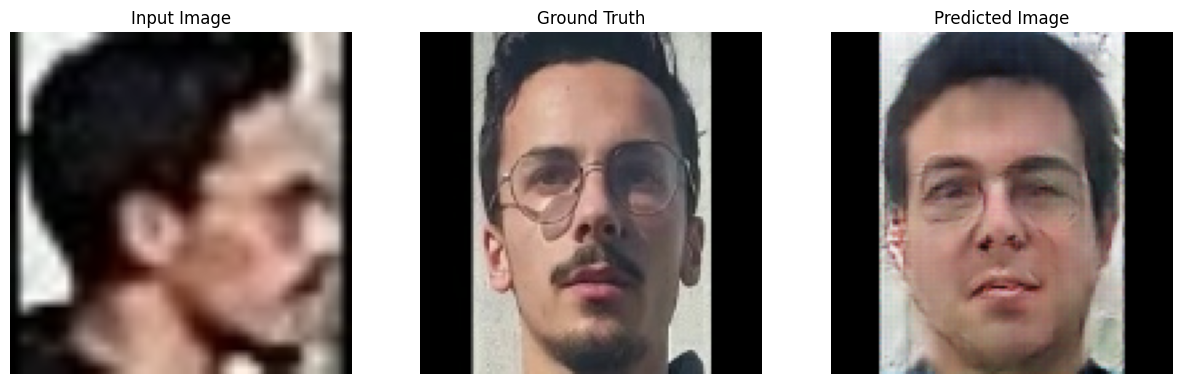

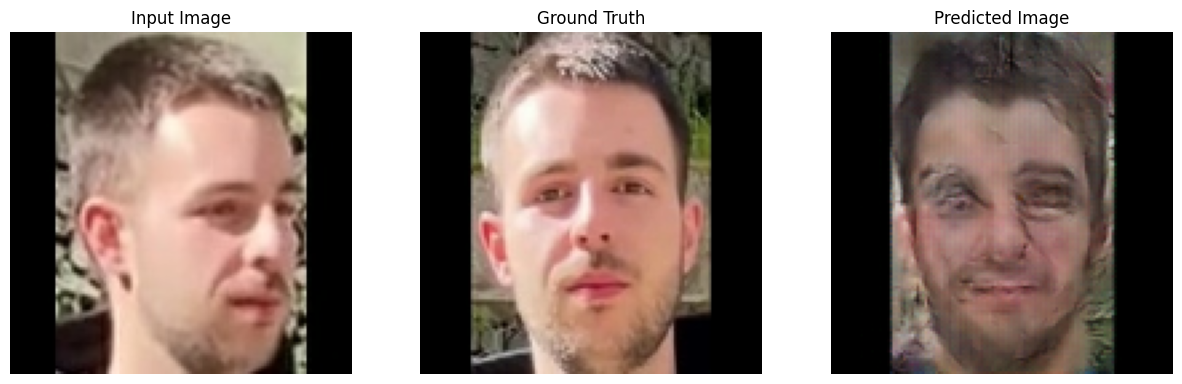

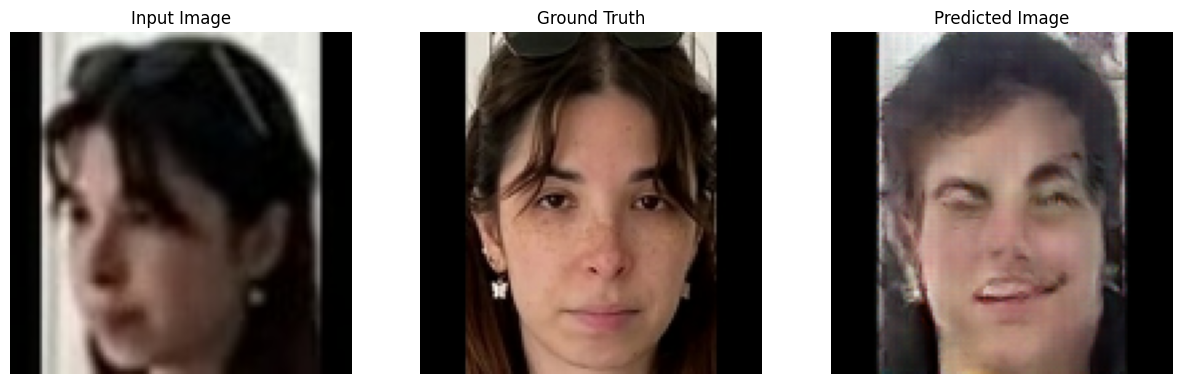

In [22]:
# Run the trained model on a few examples from the test set
print(test)
for inp, tar in test_dataset.take(10):
  generate_images(generator, inp, tar)